In [68]:
import os

In [69]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [3]:
import sys
sys.path.append('../')
sys.path.append('../..')

from utils import load_data, replace_class_and_function_names, remove_docstrings, crop_code_lines
from parser import extract_code_elements_ast, extract_code_elements_regex, CodeAugmenter

from metrics import accuracy_at_k
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer

/home/sir_timio/.local/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [9]:
import pandas as pd
import numpy as np
import scipy
from scipy.spatial.distance import cosine
import torch
from tqdm import tqdm

In [10]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/unixcoder-base")

In [13]:
result_accumulator = {}

In [14]:
np.random.seed(42)

In [15]:
def print_metrics(preds, gts, ks=[1, 3, 5]):
    for k in ks:
        print(f'accuracy@{k}: {accuracy_at_k(preds, gts, k=k)}')

In [16]:
device = "cuda"
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [17]:
model.eval()
print()

In [18]:
# settings :`cross_file_first`, `cross_file_random`, or `in_file`
settings = 'cross_file_first'
data = load_data('test', 'r', 'python', settings)

Loading data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


In [19]:
LAST_N_LINES = 3

In [20]:
target_key = 'gold_snippet_index'

In [21]:
# n_samples  = 300
# raw_samples = np.random.choice(data['easy'], n_samples)
raw_samples = data['easy']

In [22]:
symm_preds, asymm_preds, gts = [], [], []
token_counter = []

for sample in tqdm(raw_samples):
    with torch.inference_mode():
        code = crop_code_lines(sample['code'], LAST_N_LINES)
        nl_embedding = model.encode(sample['next_line'], convert_to_tensor=True, convert_to_numpy=False)
        code_embedding = model.encode(code, convert_to_tensor=True, convert_to_numpy=False)
        
        context_embedding = model.encode(sample['context'], batch_size=16, convert_to_tensor=True, convert_to_numpy=False)

        token_counter.append(sum([len(tokenizer.tokenize(c)) for c in sample['context']]))
        
        symm_dist = nl_embedding @ context_embedding.T
        asymm_dist = code_embedding @ context_embedding.T
        
        symm_preds.append(symm_dist.argsort(descending=True).detach().cpu().numpy())
        asymm_preds.append(asymm_dist.argsort(descending=True).detach().cpu().numpy())
        
        gts.append(sample[target_key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [12:28<00:00, 16.04it/s]


In [23]:
key = 'random'
result_accumulator[key] = {}
result_accumulator[key]['symm_acc@1'] = np.mean([accuracy_at_k([np.random.permutation(p) for p in asymm_preds], gts, k=1) for _ in range(100)])
result_accumulator[key]['asymm_acc@1'] = np.mean([accuracy_at_k([np.random.permutation(p) for p in asymm_preds], gts, k=1) for _ in range(100)])
result_accumulator[key]['token_counter'] = token_counter


In [24]:
for k in [1, 3, 5]:
    v = np.mean([accuracy_at_k([np.random.permutation(p) for p in asymm_preds], gts, k=k) for _ in range(100)])
    print(f'accuracy@{k}: {v}')

accuracy@1: 0.15651550000000003
accuracy@3: 0.4700463000000001
accuracy@5: 0.7825009000000002


In [25]:
key = 'baseline'
result_accumulator[key] = {}
result_accumulator[key]['symm_acc@1'] = accuracy_at_k(symm_preds, gts, k=1)
result_accumulator[key]['asymm_acc@1'] = accuracy_at_k(asymm_preds, gts, k=1)
result_accumulator[key]['token_counter'] = token_counter


In [27]:
print(key)
print('symm')
print_metrics(symm_preds, gts)
print('assym')
print_metrics(asymm_preds, gts)
print(f'\nmean tokens: {np.mean(token_counter)}')

baseline
symm
accuracy@1: 0.81292
accuracy@3: 0.951
accuracy@5: 0.98517
assym
accuracy@1: 0.2775
accuracy@3: 0.62267
accuracy@5: 0.86183

mean tokens: 5722.05025


In [28]:
# without docstrings

In [29]:
symm_preds, asymm_preds, gts = [], [], []
token_counter = []

for sample in tqdm(raw_samples):
    with torch.inference_mode():
        code = crop_code_lines(sample['code'], LAST_N_LINES)
        nl_embedding = model.encode(sample['next_line'], convert_to_tensor=True, convert_to_numpy=False)
        code_embedding = model.encode(code, convert_to_tensor=True, convert_to_numpy=False)

        new_context = [remove_docstrings(c) for c in sample['context']]
        
        context_embedding = model.encode(new_context, batch_size=16, convert_to_tensor=True, convert_to_numpy=False)

        token_counter.append(sum([len(tokenizer.tokenize(c)) for c in new_context]))
        
        symm_dist = nl_embedding @ context_embedding.T
        asymm_dist = code_embedding @ context_embedding.T
        
        symm_preds.append(symm_dist.argsort(descending=True).detach().cpu().numpy())
        asymm_preds.append(asymm_dist.argsort(descending=True).detach().cpu().numpy())
        
        gts.append(sample[target_key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [11:33<00:00, 17.30it/s]


In [30]:
key = 'without docstrings'
result_accumulator[key] = {}
result_accumulator[key]['symm_acc@1'] = accuracy_at_k(symm_preds, gts, k=1)
result_accumulator[key]['asymm_acc@1'] = accuracy_at_k(asymm_preds, gts, k=1)
result_accumulator[key]['token_counter'] = token_counter

In [31]:
print(key)
print('symm')
print_metrics(symm_preds, gts)
print('assym')
print_metrics(asymm_preds, gts)
print(f'\nmean tokens: {np.mean(token_counter)}')

without docstrings
symm
accuracy@1: 0.80467
accuracy@3: 0.95092
accuracy@5: 0.98433
assym
accuracy@1: 0.27742
accuracy@3: 0.61958
accuracy@5: 0.85867

mean tokens: 4720.647416666667


In [32]:
# Without names and docstrings

In [33]:
symm_preds, asymm_preds, gts = [], [], []
token_counter = []

for sample in tqdm(raw_samples):
    with torch.inference_mode():
        code = crop_code_lines(sample['code'], LAST_N_LINES)
        nl_embedding = model.encode(sample['next_line'], convert_to_tensor=True, convert_to_numpy=False)
        
        code_embedding = model.encode(code, convert_to_tensor=True, convert_to_numpy=False)

        augmented_context = []
        for cntx in sample['context']:
            try:
                code_elements = extract_code_elements_ast(cntx)
            except:
                try:
                    cntx = prepare_code_for_ast(cntx) # new step
                    code_elements = extract_code_elements_ast(cntx)
                except:
                    code_elements = extract_code_elements_regex(cntx)
            finally:
                aug = CodeAugmenter(cntx, code_elements)
                cntx = aug.rename_entity_names(cntx, 'cls', 'defined_classes')
                cntx = aug.rename_entity_names(cntx, 'func', 'defined_functions')
                cntx = aug.remove_comments(cntx)
                cntx = aug.remove_docstrings(cntx)
                augmented_context.append(cntx) 
        
        context_embedding = model.encode(augmented_context, batch_size=16, convert_to_tensor=True, convert_to_numpy=False)
        token_counter.append(sum([len(tokenizer.tokenize(c)) for c in augmented_context]))
        
        symm_dist = nl_embedding @ context_embedding.T
        asymm_dist = code_embedding @ context_embedding.T
        
        symm_preds.append(symm_dist.argsort(descending=True).detach().cpu().numpy())
        asymm_preds.append(asymm_dist.argsort(descending=True).detach().cpu().numpy())
        
        gts.append(sample[target_key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [27:16<00:00,  7.33it/s]


In [34]:
key = 'without class name, func, docs'
result_accumulator[key] = {}
result_accumulator[key]['symm_acc@1'] = accuracy_at_k(symm_preds, gts, k=1)
result_accumulator[key]['asymm_acc@1'] = accuracy_at_k(asymm_preds, gts, k=1)
result_accumulator[key]['token_counter'] = token_counter

In [35]:
print(key)
print('symm')
print_metrics(symm_preds, gts)
print('assym')
print_metrics(asymm_preds, gts)
print(f'\nmean tokens: {np.mean(token_counter)}')

without class name, func, docs
symm
accuracy@1: 0.52675
accuracy@3: 0.82408
accuracy@5: 0.94833
assym
accuracy@1: 0.25333
accuracy@3: 0.59467
accuracy@5: 0.84433

mean tokens: 4479.877833333333


In [36]:
# Without docstring, names, vars, attribs

In [37]:
symm_preds, asymm_preds, gts = [], [], []
token_counter = []

for sample in tqdm(raw_samples):
    with torch.inference_mode():
        code = crop_code_lines(sample['code'], LAST_N_LINES)
        nl_embedding = model.encode(sample['next_line'], convert_to_tensor=True, convert_to_numpy=False)
        
        code_embedding = model.encode(code, convert_to_tensor=True, convert_to_numpy=False)

        augmented_context = []
        for cntx in sample['context']:
            try:
                code_elements = extract_code_elements_ast(cntx)
            except:
                try:
                    cntx = prepare_code_for_ast(cntx) # new step
                    code_elements = extract_code_elements_ast(cntx)
                except:
                    code_elements = extract_code_elements_regex(cntx)
            finally:
                aug = CodeAugmenter(cntx, code_elements)
                cntx = aug.rename_entity_names(cntx, 'cls', 'defined_classes')
                cntx = aug.rename_entity_names(cntx, 'func', 'defined_functions')
                try:
                    cntx = aug.rename_entity_names(cntx, 'var', 'function_arguments')
                    cntx = aug.rename_entity_names(cntx, 'attrib', 'class_attributes')
                except:
                    pass
                cntx = aug.remove_comments(cntx)
                cntx = aug.remove_docstrings(cntx)
                augmented_context.append(cntx) 
        
        context_embedding = model.encode(augmented_context, batch_size=16, convert_to_tensor=True, convert_to_numpy=False)
        token_counter.append(sum([len(tokenizer.tokenize(c)) for c in augmented_context]))
        
        symm_dist = nl_embedding @ context_embedding.T
        asymm_dist = code_embedding @ context_embedding.T
        
        symm_preds.append(symm_dist.argsort(descending=True).detach().cpu().numpy())
        asymm_preds.append(asymm_dist.argsort(descending=True).detach().cpu().numpy())
        
        gts.append(sample[target_key])

  1%|█▌                                                                                                                        | 152/12000 [00:22<21:49,  9.05it/s]/data/home/sir_timio/workspace/repobench/repobench/pybooks/../parser/code_augmenter.py:24: FutureWarning: Possible nested set at position 20
  modified_code = re.sub(fr'\b{name}\b', new_name, modified_code)
/data/home/sir_timio/workspace/repobench/repobench/pybooks/../parser/code_augmenter.py:24: FutureWarning: Possible nested set at position 26
  modified_code = re.sub(fr'\b{name}\b', new_name, modified_code)
  6%|██████▋                                                                                                                 | 666/12000 [01:46<2:18:06,  1.37it/s]/data/home/sir_timio/workspace/repobench/repobench/pybooks/../parser/code_augmenter.py:24: FutureWarning: Possible nested set at position 31
  modified_code = re.sub(fr'\b{name}\b', new_name, modified_code)
  6%|███████▊                                        

In [38]:
key = 'without class name, func, docs, vars, attrib'
result_accumulator[key] = {}
result_accumulator[key]['symm_acc@1'] = accuracy_at_k(symm_preds, gts, k=1)
result_accumulator[key]['asymm_acc@1'] = accuracy_at_k(asymm_preds, gts, k=1)
result_accumulator[key]['token_counter'] = token_counter

In [39]:
print(key)
print('symm')
print_metrics(symm_preds, gts)
print('assym')
print_metrics(asymm_preds, gts)
print(f'\nmean tokens: {np.mean(token_counter)}')

without class name, func, docs, vars, attrib
symm
accuracy@1: 0.46058
accuracy@3: 0.77033
accuracy@5: 0.92767
assym
accuracy@1: 0.234
accuracy@3: 0.56933
accuracy@5: 0.8325

mean tokens: 4627.071166666667


In [40]:
import re

symm_preds, asymm_preds, gts = [], [], []
token_counter = []

for sample in tqdm(raw_samples):
    with torch.inference_mode():
        code = crop_code_lines(sample['code'], LAST_N_LINES)
        
        code_embedding = model.encode(code, convert_to_tensor=True, convert_to_numpy=False)

        augmented_context = []
        accum_code_elems = {}
        for cntx in sample['context']:
            try:
                code_elements = extract_code_elements_ast(cntx)
            except:
                try:
                    cntx = prepare_code_for_ast(cntx) # new step
                    code_elements = extract_code_elements_ast(cntx)
                except:
                    code_elements = extract_code_elements_regex(cntx)
            finally:
                for k, v in code_elements.items():
                    if k in accum_code_elems:
                        accum_code_elems[k].extend(code_elements[k])
                    else:
                        accum_code_elems[k] = code_elements[k]
                        
                aug = CodeAugmenter(cntx, code_elements)
                cntx = aug.rename_entity_names(cntx, 'cls', 'defined_classes')
                cntx = aug.rename_entity_names(cntx, 'func', 'defined_functions')
                try:
                    cntx = aug.rename_entity_names(cntx, 'var', 'function_arguments')
                    cntx = aug.rename_entity_names(cntx, 'attrib', 'class_attributes')
                except:
                    pass
                cntx = aug.remove_comments(cntx)
                cntx = aug.remove_docstrings(cntx)
    
                augmented_context.append(cntx) 


        next_line = sample['next_line']
        for name in accum_code_elems['defined_classes']:
            next_line = re.sub(fr'\b{name}\b', "cls", next_line)
        
        for name in accum_code_elems['defined_functions']:
            next_line = re.sub(fr'\b{name}\b', "func", next_line)
            
        nl_embedding = model.encode(next_line, convert_to_tensor=True, convert_to_numpy=False)

        context_embedding = model.encode(augmented_context, batch_size=16, convert_to_tensor=True, convert_to_numpy=False)
        token_counter.append(sum([len(tokenizer.tokenize(c)) for c in augmented_context]))
        
        symm_dist = nl_embedding @ context_embedding.T
        asymm_dist = code_embedding @ context_embedding.T
        
        symm_preds.append(symm_dist.argsort(descending=True).detach().cpu().numpy())
        asymm_preds.append(asymm_dist.argsort(descending=True).detach().cpu().numpy())
        
        gts.append(sample[target_key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [30:06<00:00,  6.64it/s]


In [41]:
key = 'next line is without keywords, context is without class name, func, docs, vars, attrib'
result_accumulator[key] = {}
result_accumulator[key]['symm_acc@1'] = accuracy_at_k(symm_preds, gts, k=1)
result_accumulator[key]['asymm_acc@1'] = accuracy_at_k(asymm_preds, gts, k=1)
result_accumulator[key]['token_counter'] = token_counter

In [42]:
print(key)
print('symm')
print_metrics(symm_preds, gts)
print('assym')
print_metrics(asymm_preds, gts)
print(f'\nmean tokens: {np.mean(token_counter)}')

next line is without keywords, context is without class name, func, docs, vars, attrib
symm
accuracy@1: 0.41975
accuracy@3: 0.74333
accuracy@5: 0.92192
assym
accuracy@1: 0.234
accuracy@3: 0.56933
accuracy@5: 0.8325

mean tokens: 4627.071166666667


In [43]:
symm_preds, asymm_preds, gts = [], [], []
token_counter = []

for sample in tqdm(raw_samples):
    with torch.inference_mode():
        code = crop_code_lines(sample['code'], LAST_N_LINES)
        
        code_embedding = model.encode(code, convert_to_tensor=True, convert_to_numpy=False)

        augmented_context = []
        for cntx in sample['context']:
            try:
                code_elements = extract_code_elements_ast(cntx)
            except:
                try:
                    cntx = prepare_code_for_ast(cntx) # new step
                    code_elements = extract_code_elements_ast(cntx)
                except:
                    code_elements = extract_code_elements_regex(cntx)
            finally:
                cntx = ""
                cntx += " ".join(code_elements['defined_classes']) + " "
                cntx += " ".join(code_elements['defined_functions']) + " "
                augmented_context.append(cntx[:-1]) 


            
        nl_embedding = model.encode(sample['next_line'], convert_to_tensor=True, convert_to_numpy=False)

        context_embedding = model.encode(augmented_context, batch_size=16, convert_to_tensor=True, convert_to_numpy=False)
        token_counter.append(sum([len(tokenizer.tokenize(c)) for c in augmented_context]))
        
        symm_dist = nl_embedding @ context_embedding.T
        asymm_dist = code_embedding @ context_embedding.T
        
        symm_preds.append(symm_dist.argsort(descending=True).detach().cpu().numpy())
        asymm_preds.append(asymm_dist.argsort(descending=True).detach().cpu().numpy())
        
        gts.append(sample[target_key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [21:05<00:00,  9.48it/s]


In [44]:
key = 'context - only class and func names'
result_accumulator[key] = {}
result_accumulator[key]['symm_acc@1'] = accuracy_at_k(symm_preds, gts, k=1)
result_accumulator[key]['asymm_acc@1'] = accuracy_at_k(asymm_preds, gts, k=1)
result_accumulator[key]['token_counter'] = token_counter

In [45]:
print(key)
print('symm')
print_metrics(symm_preds, gts)
print('assym')
print_metrics(asymm_preds, gts)
print(f'\nmean tokens: {np.mean(token_counter)}')

context - only class and func names
symm
accuracy@1: 0.787
accuracy@3: 0.91542
accuracy@5: 0.96883
assym
accuracy@1: 0.24825
accuracy@3: 0.57217
accuracy@5: 0.83292

mean tokens: 133.11675


In [46]:
symm_preds, asymm_preds, gts = [], [], []
token_counter = []

for sample in tqdm(raw_samples):
    with torch.inference_mode():
        code = crop_code_lines(sample['code'], LAST_N_LINES)
        
        code_embedding = model.encode(code, convert_to_tensor=True, convert_to_numpy=False)

        augmented_context = []
        for cntx in sample['context']:
            try:
                code_elements = extract_code_elements_ast(cntx)
            except:
                try:
                    cntx = prepare_code_for_ast(cntx) # new step
                    code_elements = extract_code_elements_ast(cntx)
                except:
                    code_elements = extract_code_elements_regex(cntx)
            finally:
                cntx = ""
                cntx += " ".join(code_elements['defined_classes']) + " "
                cntx += " ".join(code_elements['defined_functions']) + " "
                cntx += " ".join(code_elements['docstrings']) + " "
                cntx += " ".join(code_elements['function_arguments']) + " "
                cntx += " ".join(code_elements['class_attributes']) + " "
                
                
                
                augmented_context.append(cntx[:-1]) 


            
        nl_embedding = model.encode(sample['next_line'], convert_to_tensor=True, convert_to_numpy=False)

        context_embedding = model.encode(augmented_context, batch_size=16, convert_to_tensor=True, convert_to_numpy=False)
        token_counter.append(sum([len(tokenizer.tokenize(c)) for c in augmented_context]))
        
        symm_dist = nl_embedding @ context_embedding.T
        asymm_dist = code_embedding @ context_embedding.T
        
        symm_preds.append(symm_dist.argsort(descending=True).detach().cpu().numpy())
        asymm_preds.append(asymm_dist.argsort(descending=True).detach().cpu().numpy())
        
        gts.append(sample[target_key])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [21:50<00:00,  9.16it/s]


In [47]:
key = 'context - only class, func, attrib, vars names, docstrings'
result_accumulator[key] = {}
result_accumulator[key]['symm_acc@1'] = accuracy_at_k(symm_preds, gts, k=1)
result_accumulator[key]['asymm_acc@1'] = accuracy_at_k(asymm_preds, gts, k=1)
result_accumulator[key]['token_counter'] = token_counter

In [48]:
print(cntx)

 get_all_ssh_keys    


In [49]:
print(code_elements)

{'defined_classes': [], 'called_names': ['expanduser', 'dirname', 'join', 'get_all_ssh_keys', 'get'], 'defined_functions': ['get_all_ssh_keys'], 'class_attributes': [], 'function_arguments': [], 'docstrings': []}


In [50]:
print(sample['context'][-1])

PERMDIR = os.environ.get("REFACT_PERM_DIR", "") or os.path.expanduser("~/.refact/perm-storage")
TMPDIR = os.environ.get("REFACT_TMP_DIR", "") or os.path.expanduser("~/.refact/tmp")
DIR_CONFIG     = os.path.join(PERMDIR, "cfg")
DIR_WATCHDOG_D = os.path.join(PERMDIR, "cfg", "watchdog.d")
DIR_WEIGHTS    = os.path.join(PERMDIR, "weights")
DIR_LORAS      = os.path.join(PERMDIR, "loras")
DIR_LOGS       = os.path.join(PERMDIR, "logs")
DIR_UPLOADS    = os.path.join(PERMDIR, "uploaded-files")
DIR_SSH_KEYS   = os.path.join(PERMDIR, "ssh-keys")
DIR_UNPACKED = os.path.join(TMPDIR, "unpacked-files")
CONFIG_ENUM_GPUS = os.path.join(DIR_CONFIG, "gpus_enum_result.out")
CONFIG_BUSY_GPUS = os.path.join(DIR_CONFIG, "gpus_busy_result.out")
CONFIG_INFERENCE = os.path.join(DIR_CONFIG, "inference.cfg")
CONFIG_ACTIVE_LORA = os.path.join(DIR_CONFIG, "inference_active_lora.cfg")
CONFIG_HOW_TO_UNZIP = os.path.join(DIR_CONFIG, "sources_scan.cfg")
CONFIG_HOW_TO_FILETYPES = os.path.join(DIR_CONFIG, "sources_filetyp

In [51]:
print(key)
print('symm')
print_metrics(symm_preds, gts)
print('assym')
print_metrics(asymm_preds, gts)
print(f'\nmean tokens: {np.mean(token_counter)}')

context - only class, func, attrib, vars names, docstrings
symm
accuracy@1: 0.7535
accuracy@3: 0.91117
accuracy@5: 0.96408
assym
accuracy@1: 0.263
accuracy@3: 0.60225
accuracy@5: 0.84458

mean tokens: 1149.2198333333333


In [52]:
code = '''class SomeName():
    """
    Informative docstring

    with examples:
    1) a -> bc
    """
    def __init__(self, some_unique_var, another_name):
        self.foo = some_unique_var
        self.bar = another_name

    def cool_method(self, zoo):
        """inline docsting"""
        _ = SomeOuterCall()
        return 42'''

In [53]:
print(code)

class SomeName():
    """
    Informative docstring

    with examples:
    1) a -> bc
    """
    def __init__(self, some_unique_var, another_name):
        self.foo = some_unique_var
        self.bar = another_name

    def cool_method(self, zoo):
        """inline docsting"""
        _ = SomeOuterCall()
        return 42


In [54]:
elems = extract_code_elements_ast(code)

In [55]:
for k, v in elems.items():
    # v = "\n".join(v)
    print(f'{k}: {v}')

defined_classes: ['SomeName']
called_names: ['SomeOuterCall']
defined_functions: ['cool_method']
class_attributes: ['another_name', 'foo', 'some_unique_var', 'bar']
function_arguments: ['another_name', 'zoo', 'some_unique_var']
docstrings: ['inline docsting', 'Informative docstring\n\nwith examples:\n1) a -> bc']


In [56]:
aug = CodeAugmenter(code, elems)
code = aug.remove_comments(code)
code = aug.remove_docstrings(code)

code = aug.rename_entity_names(code, 'cls', 'defined_classes')
code = aug.rename_entity_names(code, 'func', 'defined_functions')
# try:

code = aug.rename_entity_names(code, 'call_func', 'called_names')
code = aug.rename_entity_names(code, 'var', 'function_arguments')
code = aug.rename_entity_names(code, 'attrib', 'class_attributes')
# except:
    # pass

In [57]:
print(code)

class cls_0():
                                                                            
    def __init__(self, var_2, var_0):
        self.attrib_1 = var_2
        self.attrib_3 = var_0

    def func_0(self, var_1):
                             
        _ = call_func_0()
        return 42


In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
for k, v in result_accumulator.items():
    print(k)
    print(v.keys())
    break

random
dict_keys(['symm_acc@1', 'asymm_acc@1', 'token_counter'])


In [60]:
from collections import namedtuple
exp = namedtuple("Exp", "name symm_acc_1 asymm_acc_1 context_size")

In [71]:
df.to_csv('result.csv', index=False)

In [61]:
data_for_plot = {
    "Experiment": [],
    "Symmetric Accuracy@1": [],
    "Asymmetric Accuracy@1": [],
    "Mean context size": []
}
for k, v in result_accumulator.items():
    data_for_plot['Experiment'].append(k)
    data_for_plot['Symmetric Accuracy@1'].append(v['symm_acc@1'])
    data_for_plot['Asymmetric Accuracy@1'].append(v['asymm_acc@1'])
    data_for_plot['Mean context size'].append(np.mean(v['token_counter']))

In [74]:
for n in data_for_plot['Experiment']:
    print(n)

random
baseline
without docstrings
without class name, func, docs
without class name, func, docs, vars, attrib
next line is without keywords, context is without class name, func, docs, vars, attrib
context - only class and func names
context - only class, func, attrib, vars names, docstrings


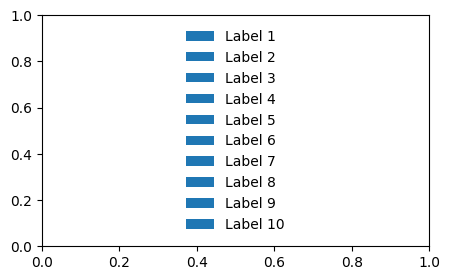

In [77]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define your colors and labels
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
labels = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6', 'Label 7', 'Label 8', 'Label 9', 'Label 10']

# Create a list of patches
patches = [Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

# Plot the legend
plt.figure(figsize=(5, 3))
plt.legend(handles=patches, loc='center', frameon=False)

plt.show()


In [62]:
df = pd.DataFrame(data_for_plot)

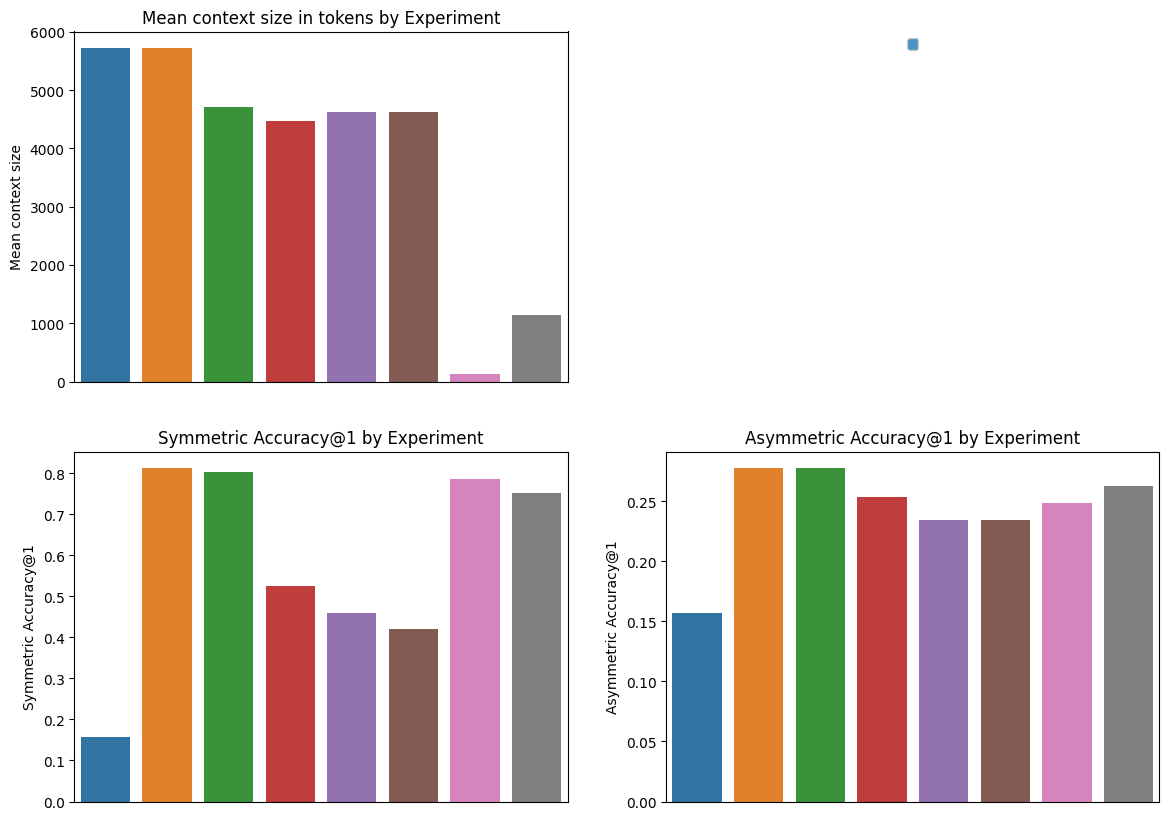

In [63]:
plt.figure(figsize=(14, 10))


plt.subplot(2, 2, 1) 
sns.barplot(x="Experiment", y="Mean context size", hue="Experiment", data=df)
plt.title('Mean context size in tokens by Experiment')
plt.xlabel('')
plt.xticks([]) 
# plt.legend([],[], frameon=False) 

plt.subplot(2, 2, 3) 
sns.barplot(x="Experiment", y="Symmetric Accuracy@1", hue="Experiment", data=df)
plt.title('Symmetric Accuracy@1 by Experiment')
plt.xlabel('')
plt.xticks([]) 
# plt.legend([],[], frameon=False) 

plt.subplot(2, 2, 4)
sns.barplot(x="Experiment", y="Asymmetric Accuracy@1", hue="Experiment", data=df)
plt.title('Asymmetric Accuracy@1 by Experiment')
plt.xlabel('')
plt.xticks([]) 
# plt.legend([],[], frameon=False) 

plt.subplot(2, 2, 2)
plt.axis('off')
legend = plt.legend(loc='upper center', shadow=False, labels=df['Experiment'].values)
legend.get_frame().set_facecolor('C0')

# plt.tight_layout()
plt.show()

In [64]:
df['Experiment'].values

array(['random', 'baseline', 'without docstrings',
       'without class name, func, docs',
       'without class name, func, docs, vars, attrib',
       'next line is without keywords, context is without class name, func, docs, vars, attrib',
       'context - only class and func names',
       'context - only class, func, attrib, vars names, docstrings'],
      dtype=object)

In [65]:
df['Experiment'].values

array(['random', 'baseline', 'without docstrings',
       'without class name, func, docs',
       'without class name, func, docs, vars, attrib',
       'next line is without keywords, context is without class name, func, docs, vars, attrib',
       'context - only class and func names',
       'context - only class, func, attrib, vars names, docstrings'],
      dtype=object)

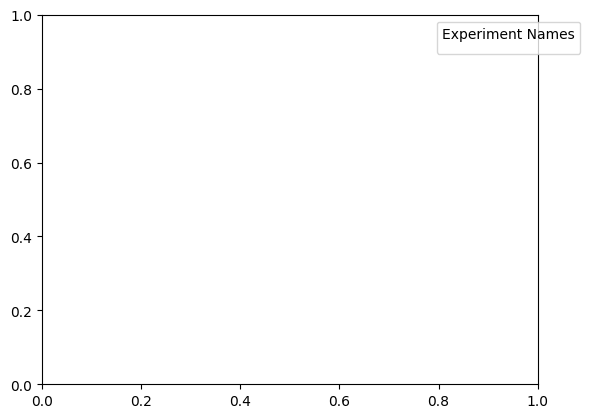

In [66]:
plt.legend(title='Experiment Names', loc='upper right', bbox_to_anchor=(1.1, 1), labels=df['Experiment'].values)

In [67]:
result_list

NameError: name 'result_list' is not defined

In [ ]:
bar_width = 0.35
index = range(len(result_accumulator))

# Creating the bar plot
plt.figure(figsize=(12, 6))

# Plotting symmetric accuracy
plt.bar(index, symm_acc, bar_width, label='Symmetric Accuracy @1', color='blue')

# Plotting asymmetric accuracy
plt.bar([i + bar_width for i in index], asymm_acc, bar_width, label='Asymmetric Accuracy @1', color='green')

plt.xlabel('Experiments')
plt.ylabel('Accuracy')
plt.title('Experiment Results in Bar Chart')
plt.xticks([i + bar_width / 2 for i in index], experiments, rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# replace everything from context & next line
# unique

In [ ]:
raw_samples[0].keys()

In [ ]:
cntx.count('class')

In [ ]:
# settings :`cross_file_first`, `cross_file_random`, or `in_file`
settings = 'cross_file_first'
raw_data = load_data('test', 'r', 'python', settings)

In [ ]:
data = {
    "code_length": [],
    "num_func_def": [],
    "num_class_def": [],
    "is_gold_snippet": [],
    "num_lines": [],
}

for sample in raw_data['easy']:
    context = sample['context']
    gold_snippet_index = sample['gold_snippet_index']
    for i, snippet in enumerate(context):
        is_gold = (i == gold_snippet_index)
        data["code_length"].append(len(snippet))
        data["num_class_def"].append(snippet.count('class '))
        data["num_func_def"].append(snippet.count('def '))
        data["num_lines"].append(snippet.count('\n'))
        data["is_gold_snippet"].append(is_gold)

df = pd.DataFrame(data)

In [ ]:
def plot_boxplot(df, column, title, hue="is_gold_snippet"):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=hue, y=column, data=df)
    plt.title(title)
    plt.show()

def plot_histogram(df, column, title, hue="is_gold_snippet"):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, hue=hue, kde=True)
    plt.title(title)
    plt.show()

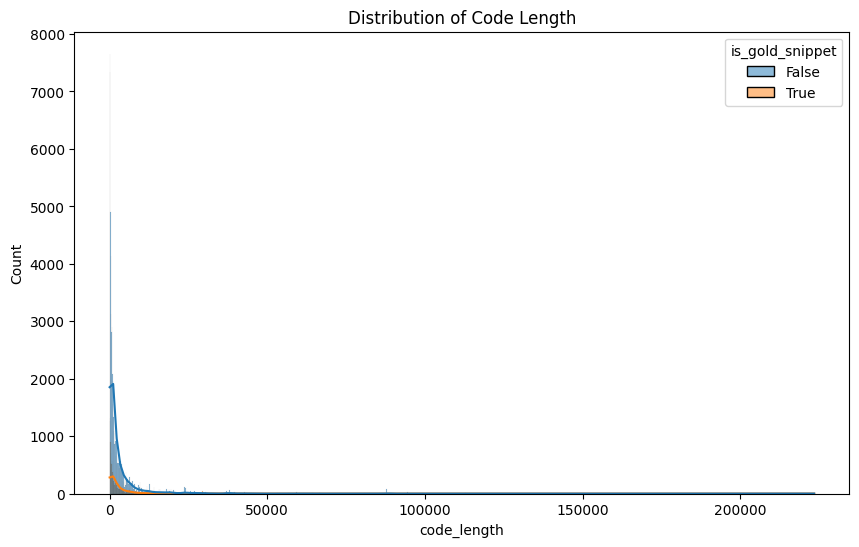

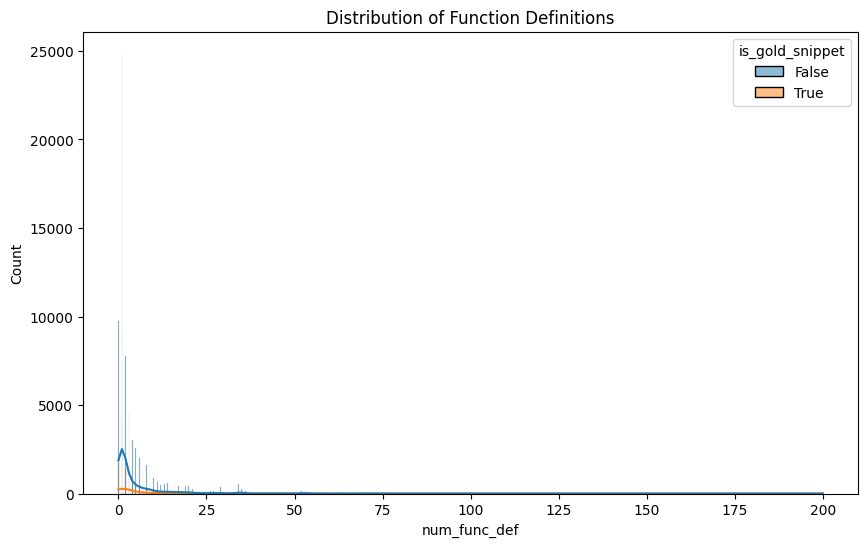

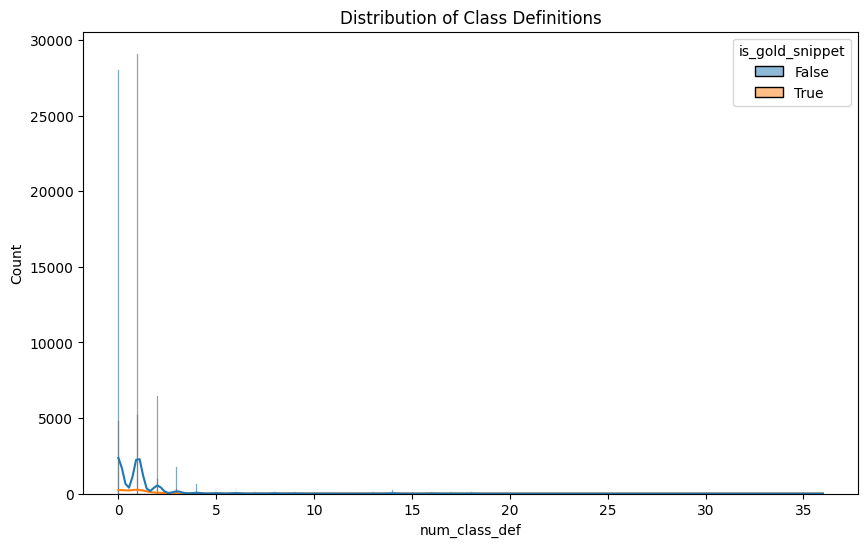

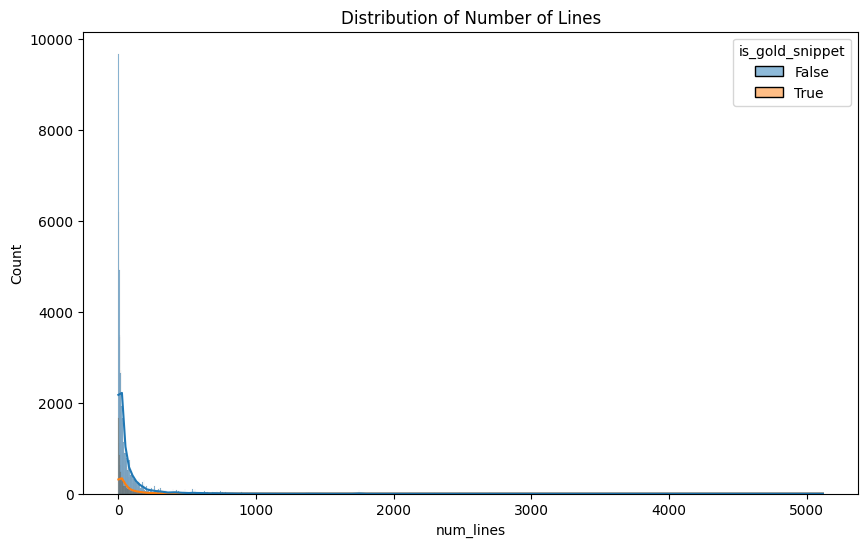

In [83]:
plot_histogram(df, "code_length", "Distribution of Code Length")
plot_histogram(df, "num_func_def", "Distribution of Function Definitions")
plot_histogram(df, "num_class_def", "Distribution of Class Definitions")
plot_histogram(df, "num_lines", "Distribution of Number of Lines")

In [89]:
full_lens = []
cutted_lens  = []
# for sample in tqdm(raw_data['easy']):
for sample in tqdm(np.random.choice(raw_data['easy'], 1000)):
    for cntx in sample['context']:
        full_lens.append(len(cntx))
        try:
            code_elements = extract_code_elements_ast(cntx)
        except:
            try:
                cntx = prepare_code_for_ast(cntx) # new step
                code_elements = extract_code_elements_ast(cntx)
            except:
                code_elements = extract_code_elements_regex(cntx)
        finally:
            cntx = ""
            cntx += " ".join(code_elements['defined_classes']) + " "
            cntx += " ".join(code_elements['defined_functions']) + " "
            cntx += " ".join(code_elements['class_attributes']) + " "
            cntx += " ".join(code_elements['function_arguments']) + " "
        cutted_lens.append(len(cntx))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.82it/s]


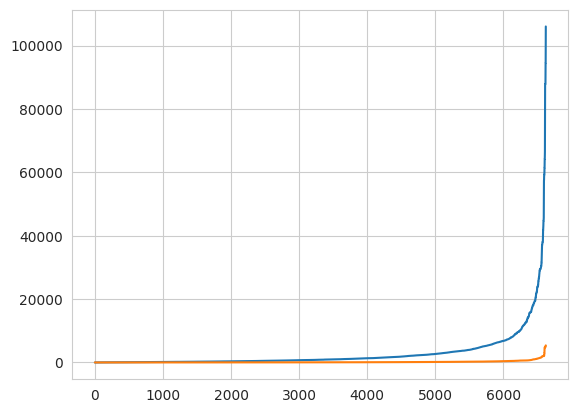

In [92]:
plt.plot(sorted(full_lens))
plt.plot(sorted(cutted_lens))


In [95]:
np.mean(cutted_lens) / np.mean(full_lens)

0.05674861518349617

In [94]:
print(np.mean(full_lens))
print(np.mean(cutted_lens))

2896.509208937198
164.37288647342996


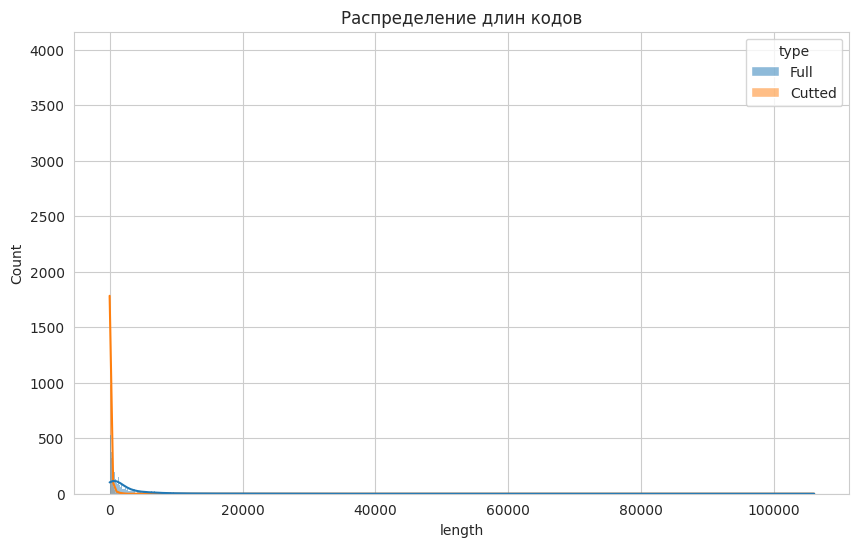

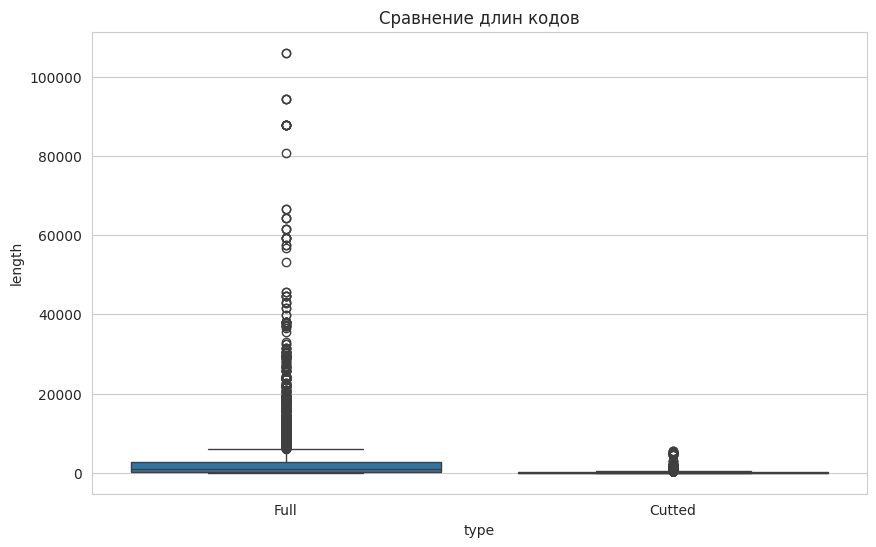

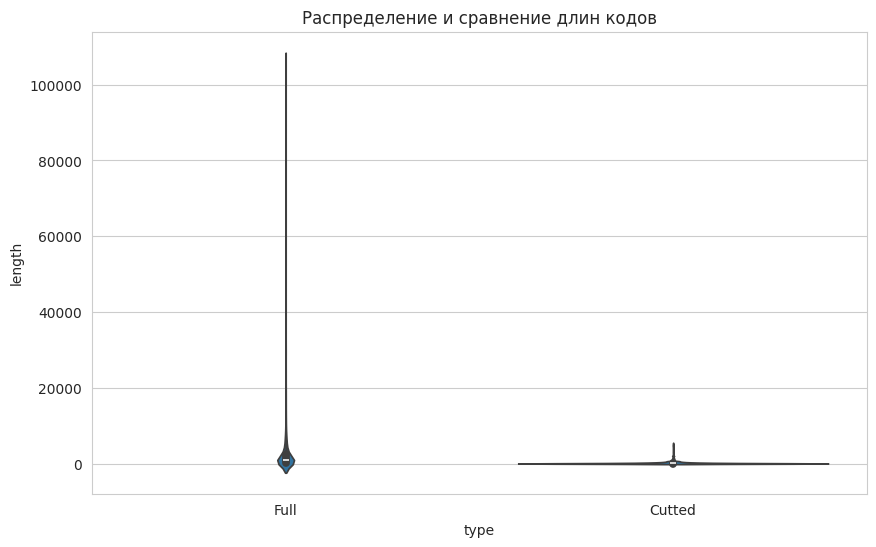

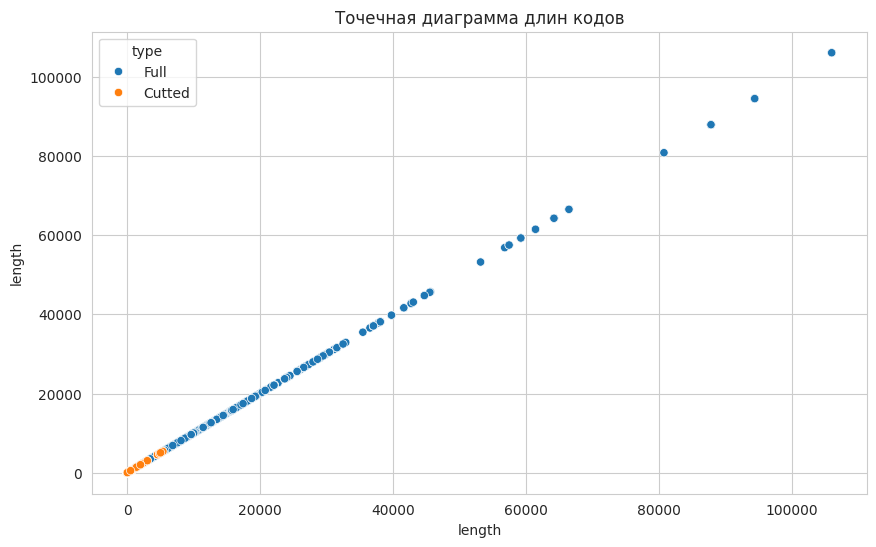

In [91]:

# Установка стиля для графиков
sns.set_style("whitegrid")

# Подготовка данных
df_full = pd.DataFrame({'length': full_lens, 'type': 'Full'})
df_cutted = pd.DataFrame({'length': cutted_lens, 'type': 'Cutted'})
df_combined = pd.concat([df_full, df_cutted])

# Гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined, x='length', hue='type', kde=True)
plt.title('Распределение длин кодов')
plt.show()

# Боксплоты
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='length', data=df_combined)
plt.title('Сравнение длин кодов')
plt.show()

# Виолончельные диаграммы
plt.figure(figsize=(10, 6))
sns.violinplot(x='type', y='length', data=df_combined)
plt.title('Распределение и сравнение длин кодов')
plt.show()

# Точечные диаграммы
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_combined, x='length', y='length', hue='type')
plt.title('Точечная диаграмма длин кодов')
plt.show()

In [96]:
del model

In [97]:
del symm_dist, asymm_dist

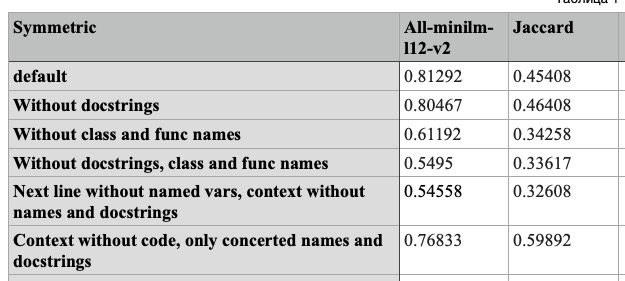

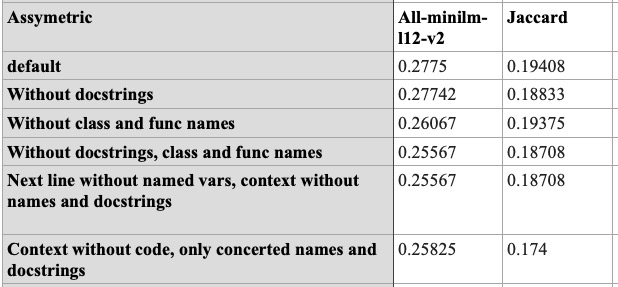